In [32]:
import copy

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from typing import Union
from torch.utils.data import Subset

from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import get_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)
from src.audio_utils import split_waveform, CepstralNormalization

## Problem Definition: Speaker Classification

Our project consists of identifying a speaker based on recorded audio samples. The model is trained from multiple audio samples for many speakers. Given a new audio sample, the model should identify which of the speakers it belongs to.  

<center><img src="images/problem_definition.png" width="400" height="400"></center>

## Dataset
There are multiple datasets that include speaker_id and audio samples. Up to this point, we decided to start with Librispeech as it provides hours of recorded audio samples in relatively noise-free environments. 

LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

There are multiple sizes of the dataset. In this notebook we are using **dev-clean** which is the development dataset. In other notebooks, we will use a version with more samples 

In [2]:
dataset_name = "librispeech"
url = 'train-clean-100'
dataset = get_dataset(dataset_name, url=url)

You're about to download librispeech with url train-clean-100

 Done downloading


# Data Visualization

The data extract from librispeech includes audio samples recorded as waveforms. In audio processing algorithm, it is standard practice to extract data by transforming the waveforms into a spectrogram or a varation of a spectrogram called a Mel-frequency cepstrum (MFC). This is done to remove unnecessary data from the waveforms and keep important information such as time, frequency, and amplitude.   

Visualizing data in random sample from the dataset

In [3]:
# visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [4]:
# waveform_lengths = []
# sample_rates = []
# transcript_lengths = []
# speaker_ids = []
# audio_durations = []
# waveforms = []
# transcripts = []

# for i in tqdm(range(dataset.__len__())):
#     (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
#     speaker_ids.append(speaker_id)

#     waveform_lengths.append(waveform[0].shape[0])
#     sample_rates.append(sample_rate)
#     transcript_lengths.append(len(transcript))
#     waveforms.append(waveform[0].numpy())
#     transcripts.append(transcript)
#     num_channels, num_frames = waveform.shape
#     duration = num_frames / sample_rate
#     audio_durations.append(duration)

# dataset_stats = pd.DataFrame.from_dict(
# {
#     "waveform_lengths" : waveform_lengths,
#     "sample_rates" : sample_rates,
#     "transcript_lengths" : transcript_lengths,
#     "audio_durations" : audio_durations,
# }
#     )

In [5]:
# df = calculate_statistics(dataset)

We can see from the above charts that there is a lot of variance in the audio duration. Our model needs to take consistent sizes of audio.

In [6]:
# df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
# df_spkr['speaker_id'] = speaker_ids
# df_spkr['duration'] = audio_durations

In [7]:
# df_spkr.to_csv('df_speaker_ids.csv')
df_spkr = pd.read_csv('df_speaker_ids.csv')

In [8]:
# df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset.

Number of samples for each speaker

In [9]:
# df_spkr.groupby('speaker_id').size().sort_values()

We can see than in this dataset, some speakers have 36 samples only. This could potentially be little data to train a model. 

Unique speaker ids

In [8]:
np.unique(df_spkr['speaker_id'])

array([  19,   26,   27,   32,   39,   40,   60,   78,   83,   87,   89,
        103,  118,  125,  150,  163,  196,  198,  200,  201,  211,  226,
        229,  233,  248,  250,  254,  289,  298,  302,  307,  311,  322,
        328,  332,  374,  403,  405,  412,  426,  441,  445,  446,  458,
        460,  481,  587,  625,  669,  696,  730,  831,  839,  887,  909,
        911, 1034, 1040, 1069, 1081, 1088, 1098, 1116, 1183, 1235, 1246,
       1263, 1334, 1355, 1363, 1447, 1455, 1502, 1553, 1578, 1594, 1624,
       1723, 1737, 1743, 1841, 1867, 1898, 1926, 1963, 1970, 1992, 2002,
       2007, 2092, 2136, 2159, 2182, 2196, 2289, 2384, 2391, 2416, 2436,
       2514, 2518, 2691, 2764, 2817, 2836, 2843, 2893, 2910, 2911, 2952,
       2989, 3112, 3168, 3214, 3235, 3240, 3242, 3259, 3374, 3436, 3440,
       3486, 3526, 3607, 3664, 3699, 3723, 3807, 3830, 3857, 3879, 3947,
       3982, 3983, 4014, 4018, 4051, 4088, 4137, 4160, 4195, 4214, 4267,
       4297, 4340, 4362, 4397, 4406, 4441, 4481, 46

Visualize spectrograms

In [11]:
# df_speaker_waveform = pd.DataFrame(columns=['speaker_id', 'waveform', 'transcript'])
# df_speaker_waveform['speaker_id'] = speaker_ids
# df_speaker_waveform['waveform'] = waveforms
# df_speaker_waveform['transcript'] = transcripts

In [12]:
# df_speaker_waveform[df_speaker_waveform['speaker_id']==84].head()

In [13]:
# num_cols = 3
# for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
#     fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
#     waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
#     idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
#     for j, wave in enumerate(waves[:num_cols]):
#         ax[j].specgram(wave, Fs=sample_rate)
#         ax[j].set_title(f'speaker {speaker_id}, df.index: {idx[j]}')

#         plt.tight_layout()

Visualize MFCC spectrograms

In [14]:
# num_cols = 3
# for speaker_id in np.unique(df_speaker_waveform['speaker_id'])[:8]:
#     fig, ax = plt.subplots(1, num_cols, figsize=(12, 3))
#     waves = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].values
#     idx = df_speaker_waveform[df_speaker_waveform['speaker_id']==speaker_id]['waveform'].index
#     for j, wave in enumerate(waves[:num_cols]):
#         mfccs = librosa.feature.mfcc(y=wave.flatten(), n_mfcc=13, sr=sample_rate)
#         img = librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate, ax=ax[j])
#         ax[j].set_title(f'speaker: {speaker_id}, df.index: {idx[j]}')
#         fig.colorbar(img, ax=ax[j], format="%+2.f dB")
#     plt.tight_layout()

Visualization of each channel in MFCC

In [15]:
# plt.figure(figsize=(12, 8))
# for i in range(mfccs.shape[0]):
#     plt.plot(mfccs[i,:], label=f"channel_{i}")
# plt.legend()

## Preprocessing

<center><img src="images/preprocessing.png" height="400"></center>

The preprocessing pipeline consists of the following steps:
1. Transform waveforms to MFCC
2. (optional) Perform Cepstral Normalization on the MFCC
3. Transform MFCC (2D-array) to a greyscale image

**Cepstral normalization** is the process of normalizing the MFCCs at every channel. The first channels of the MFCC carry the most important features; therefore, channels should not be mixed during normalization. At every channel, the values are normalized by subtracting the mean and dividing by the standard deviation: 
$$(X_{channel} - \mu_{channel})/\sigma_{channel} $$

Special consideration had to be taken during splitting of the data into train, validation, and test as well as during normalization. 

1. To ensure that each speaker_id is represent in each set, before splitting the audio samples were grouped by speaker id. Then the samples in each speaker_id are splitted in x% train, y% validation, z% test

2. To ensure there is no data leakage between training and other sets during normalization, **the Cepstral Normalizer only uses MFCCs from the training set during fitting.**

In [9]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = array_to_image_transform(mfcc)
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [10]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [11]:
def create_mfcc_databases(dataset, window_size : int, sample_rate : int, speaker_dict : dict, number_spectral_coefficients : int):
    """
    Creates two databases from an audio dataset e.g. librispeech
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz    
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    Returns
    -------
    speaker_mfcc_db : pd.DataFrame 
        df with shape (index_id, speaker_id, mfcc_id)
    
    mfcc_channel_db : pd.DataFrame
        df with shape (mfcc_id, channel_id)
    
    """
    try:
        speaker_mfcc_db = pd.read_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db = pd.read_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
    
    except FileNotFoundError:
        speaker_mfcc_db = pd.DataFrame(columns=["speaker_id", "mfcc_id"])
        mfcc_channel_db = pd.DataFrame(columns=["mfcc_id"]+[f"channel_{i}" for i in range(number_spectral_coefficients)]).set_index('mfcc_id')

        idx = 0

        print('Creating a database. Hold tight...')
        for i in tqdm(range(dataset.__len__())):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, window_size) # split waveforms into consistent chunks

            for chunk in splitted_waveform: # transform waveforms into MFCC spectrograms
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=sample_rate)

                speaker_mfcc_db.loc[idx, "speaker_id"] = speaker_dict[speaker_id]
                speaker_mfcc_db.loc[idx, "mfcc_id"] = idx

                for j in range(number_spectral_coefficients):
                    mfcc_channel_db.loc[idx, f"channel_{j}"] = 1
                    mfcc_channel_db.at[idx, f"channel_{j}"] = mfccs[j, :]
                
                idx += 1

        speaker_mfcc_db.to_pickle(f'speaker_mfcc_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')
        mfcc_channel_db.to_pickle(f'mfcc_channel_db_{window_size}_{sample_rate}_{number_spectral_coefficients}.pkl')

    return speaker_mfcc_db, mfcc_channel_db

In [12]:
def split_train_test_val(speaker_mfcc_db : pd.DataFrame, train_pct : float, val_pct : float, 
                         test_pct : float) -> Union[list[int], list[int], list[int]]:
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:int(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[int(len_ids * train_pct):int(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[int(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [13]:
def get_datasets(base_dataset, speaker_dict : dict, window_size : int, sample_rate : int, train_pct : float, 
                 val_pct : float, test_pct : float, number_spectral_coefficients : int, cepstral_normalize : bool, 
                 transform=None) -> Union[Dataset, Dataset, Dataset]:
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    base_dataset : 
        A pytorch audio dataset like librispeech
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db, mfcc_channel_db = create_mfcc_databases(base_dataset, window_size=window_size, sample_rate=sample_rate, speaker_dict=speaker_dict, number_spectral_coefficients=number_spectral_coefficients)

    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [15]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 200

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = None

In [16]:
speaker_dict = speaker_encoder(np.unique(df_spkr['speaker_id']))
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(dataset, 
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.90it/s]


In [42]:
train_set = Subset(mfcc_dataset_train, range(0, mfcc_dataset_train.__len__(), 10))
val_set = Subset(mfcc_dataset_val, range(0, mfcc_dataset_val.__len__(), 10))

In [43]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [44]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(), 

(44653, 14917, 15020)

In [45]:
train_loader.__len__(), val_loader.__len__()

(23, 8)

Visualize a random sample from the dataloader to verify it looks as expected

torch.Size([1, 13, 126]) torch.Size([])


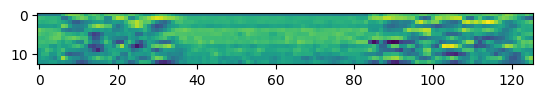

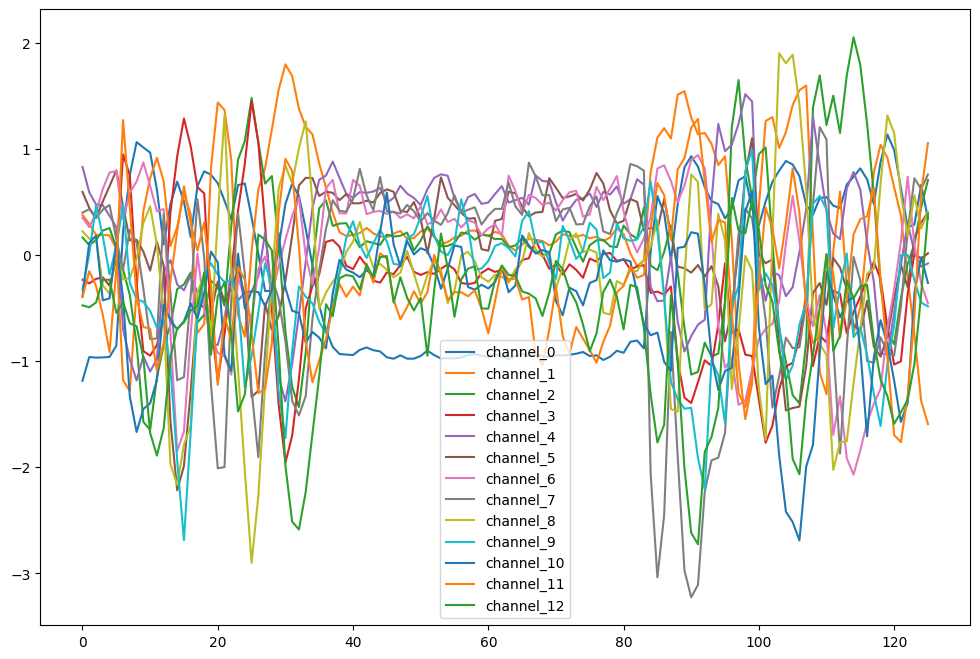

In [19]:
random_sample = np.random.randint(0, 2300)
sample_mfcc, sample_speaker = mfcc_dataset_train.__getitem__(random_sample)

print(sample_mfcc.shape, sample_speaker.shape)

mfcc_arr = sample_mfcc.to('cpu').numpy().reshape(13, 126)
plt.figure()
plt.imshow(mfcc_arr)
plt.figure(figsize=(12, 8))
for i in range(mfcc_arr.shape[0]):
    plt.plot(mfcc_arr[i,:], label=f"channel_{i}")
plt.legend()

## Model Training

In [26]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    val_acc = []

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            mfcc, speakers = data
            outputs = model(mfcc)

            loss = criterion(outputs, speakers)
            total_loss += loss.item()
            total_epoch += len(speakers)
            val_acc.append(get_accuracy(model, loader))

        loss = float(total_loss) / (i + 1)
        val_acc = np.mean(val_acc)
    return loss, val_acc

def get_accuracy(model, dataloader):
    #select index with maximum prediction score
    correct = 0
    total = 0
    for data in dataloader:
        mfcc, labels = data
        output = model(mfcc)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2, plot_loss=True):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
        
    if torch.cuda.is_available():
        model = model.to(torch.device('cuda:0'))
    
    for epoch in tqdm(range(num_epochs)): 
        total_train_loss = 0.0
        total_epoch = 0
        total_train_acc = []
        correct = 0.0
        total = 0.0
        
        model.train()
        
        for i, data in enumerate(train_loader):
            mfcc, speakers = data
                        
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = model(mfcc)
            loss = criterion(outputs, speakers)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(speakers)
            total_train_acc.append(get_accuracy(model, train_loader))
            
        model.eval()
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = np.mean(total_train_acc)        
        val_loss[epoch], val_acc[epoch] = evaluate(model, val_loader, criterion)
        
        if epoch % print_every == 0:    
            print(f"Epoch {epoch}: \n \
            Train loss {train_loss[epoch]:.3f} | Val loss {val_loss[epoch]:.3f} \n \
            Train acc {train_acc[epoch]:.3f} | Val acc {val_acc[epoch]:.3f} \n")
            
            
    if plot_loss:
        n = len(train_loss) # number of epochs
        plt.figure()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')

        plt.figure()
        plt.title("Train vs Validation Accuracy")
        plt.plot(range(1,n+1), train_acc, label="Train")
        plt.plot(range(1,n+1), val_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')   

In [27]:
class FCN(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_size):
        super(FCN, self).__init__()

        self.fc1 = nn.Linear(3 * 11 * 124, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
class CNN(nn.Module):
    def __init__(self, hidden_layers, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(1 * 13 * 126, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = x.view(-1, 1 * 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [46]:
# model hyperparameters
hidden_layers = 300
output_size = len(np.unique(df_spkr['speaker_id']))
lr = 0.01
momentum = 0.9
num_epochs = 30

model = CNN(hidden_layers=hidden_layers, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
num_epochs = num_epochs

In [ ]:
train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

  3%|██▏                                                              | 1/30 [00:20<09:58, 20.65s/it]

Epoch 0: 
             Train loss 5.529 | Val loss 5.523 
             Train acc 0.004 | Val acc 0.004 



  7%|████▎                                                            | 2/30 [00:40<09:33, 20.47s/it]

Epoch 1: 
             Train loss 5.527 | Val loss 5.521 
             Train acc 0.004 | Val acc 0.004 



 10%|██████▌                                                          | 3/30 [01:02<09:25, 20.93s/it]

Epoch 2: 
             Train loss 5.526 | Val loss 5.520 
             Train acc 0.004 | Val acc 0.004 



 13%|████████▋                                                        | 4/30 [01:24<09:17, 21.45s/it]

Epoch 3: 
             Train loss 5.524 | Val loss 5.519 
             Train acc 0.004 | Val acc 0.004 



 17%|██████████▊                                                      | 5/30 [01:46<08:59, 21.57s/it]

Epoch 4: 
             Train loss 5.511 | Val loss 5.458 
             Train acc 0.004 | Val acc 0.005 



 20%|█████████████                                                    | 6/30 [02:09<08:45, 21.91s/it]

Epoch 5: 
             Train loss 5.355 | Val loss 5.016 
             Train acc 0.013 | Val acc 0.022 



 23%|███████████████▏                                                 | 7/30 [02:31<08:26, 22.01s/it]

Epoch 6: 
             Train loss 4.426 | Val loss 3.788 
             Train acc 0.080 | Val acc 0.111 



 27%|█████████████████▎                                               | 8/30 [02:53<08:04, 22.03s/it]

Epoch 7: 
             Train loss 3.375 | Val loss 3.287 
             Train acc 0.199 | Val acc 0.204 



 30%|███████████████████▌                                             | 9/30 [03:16<07:47, 22.28s/it]

Epoch 8: 
             Train loss 2.853 | Val loss 2.888 
             Train acc 0.296 | Val acc 0.269 



 33%|█████████████████████▎                                          | 10/30 [03:39<07:31, 22.58s/it]

Epoch 9: 
             Train loss 2.512 | Val loss 2.738 
             Train acc 0.358 | Val acc 0.309 



 37%|███████████████████████▍                                        | 11/30 [04:00<07:02, 22.22s/it]

Epoch 10: 
             Train loss 2.316 | Val loss 2.629 
             Train acc 0.404 | Val acc 0.332 



 40%|█████████████████████████▌                                      | 12/30 [04:22<06:35, 21.99s/it]

Epoch 11: 
             Train loss 2.208 | Val loss 2.587 
             Train acc 0.431 | Val acc 0.349 



 43%|███████████████████████████▋                                    | 13/30 [04:44<06:14, 22.04s/it]

Epoch 12: 
             Train loss 2.087 | Val loss 2.478 
             Train acc 0.453 | Val acc 0.383 



 47%|█████████████████████████████▊                                  | 14/30 [05:06<05:51, 21.96s/it]

Epoch 13: 
             Train loss 1.950 | Val loss 2.457 
             Train acc 0.488 | Val acc 0.379 



 50%|████████████████████████████████                                | 15/30 [05:27<05:27, 21.84s/it]

Epoch 14: 
             Train loss 1.887 | Val loss 2.512 
             Train acc 0.493 | Val acc 0.377 



 53%|██████████████████████████████████▏                             | 16/30 [05:49<05:04, 21.77s/it]

Epoch 15: 
             Train loss 1.847 | Val loss 2.436 
             Train acc 0.512 | Val acc 0.422 



 57%|████████████████████████████████████▎                           | 17/30 [06:10<04:42, 21.70s/it]

Epoch 16: 
             Train loss 1.772 | Val loss 2.410 
             Train acc 0.531 | Val acc 0.420 



 60%|██████████████████████████████████████▍                         | 18/30 [06:32<04:19, 21.61s/it]

Epoch 17: 
             Train loss 1.752 | Val loss 2.406 
             Train acc 0.535 | Val acc 0.401 



In [ ]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [ ]:
test_model(model, test_loader)

In [ ]:
speaker_dict # {original_speaker_id, encoded_speaker_id}

In [ ]:
classes = [str(speaker_id) for speaker_id in range(len(np.unique(df_spkr['speaker_id'])))]
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for mfcc, speakers in test_loader:
    outputs = model(mfcc)
    _, predicted = torch.max(outputs.data, 1)
    # print(f"predicted: {predicted}, actual: {speakers}")
    for label, prediction in zip(speakers, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## AlexNet

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11,11), stride=(4,4), padding=(2,2))

In [ ]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [ ]:
#Modify the final output layer

alexnet.classifier.add_module("6",nn.Linear(4096, 500))
alexnet.classifier.add_module("7",nn.LeakyReLU())
alexnet.classifier.add_module("8",nn.Linear(500, 40))
# alexnet.classifier.add_module("9", nn.LogSoftmax(dim = 1))
alexnet

In [ ]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(alexnet.parameters())


def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/2399 
        avg_train_acc = train_acc/2399

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/686 
        avg_valid_acc = valid_acc/686

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
import time

In [ ]:
alexnet = alexnet.to('cuda')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 20
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tacc, vacc, tloss, vloss in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


In [ ]:
n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [ ]:
for mfcc, speakers in train_loader:
    break

In [ ]:
plt.imshow(np.transpose(mfcc[0].to('cpu').numpy(), [1, 2, 0]))